## 0. Carga de librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from math import log
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection

# 1. Modelo determinista
Vamos a implementar Lotka-Volterra para $N=4$ especies. Usaremos la expresión
$$
\frac{dx_i}{dt} = r_ix_i\left( 1- \sum_{j=1}^N a_{ij}x_j \right)
$$

In [2]:
# generamos las funciones para cada especie

def system(t,x,r,a):
    '''
    :param x: vector de longitud N
    :param r: vector de tasa de crecimiento (r_i)
    :param a: matriz (N,N) con los coeficientes a_ij
    :return: numpy array
    '''
    N = len(x)
    dxdt = np.zeros(N)
    for i in range(N):
        interaction = np.sum(a[i,:]*x)
        dxdt[i] = r[i] * x[i] * (1 - interaction)
    return dxdt

## 1.1. Evolución temporal

In [3]:
# resolvemos con integración

N=4
r = np.array(
    [1, 0.72, 1.53, 1.27]
)

a = np.array([
    [1, 1.09, 1.52, 0],
    [0, 1, 0.44, 1.36],
    [2.33, 0, 1, 0.47],
    [1.21, 0.51, 0.35, 1]
])

x0 = np.array([0.5, 0.5, 0.5, 0.5])
t_span = (0, 500) # con ~1e3 queda chulo
t_eval =np.linspace(t_span[0],t_span[1], 10000) 
sol = solve_ivp(system, t_span, x0, args=(r,a), t_eval = t_eval)
print(len(sol.y[0]))

10000


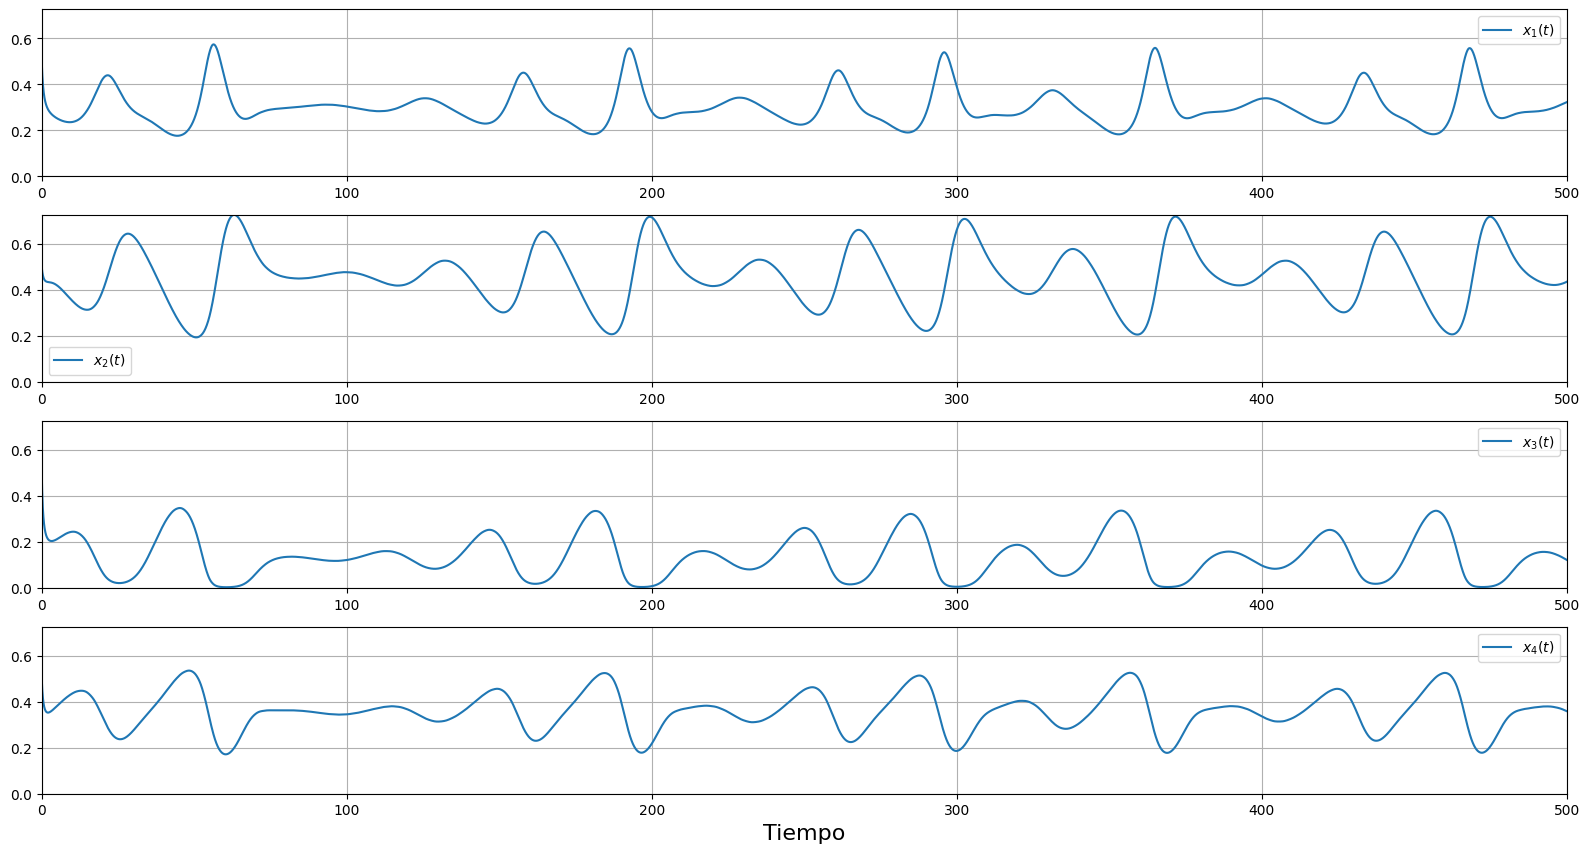

In [4]:
# %matplotlib notebook

# creamos la gráfica
fig, ax = plt.subplots(4, 1, figsize=(16,9))

ax[0].plot(sol.t, sol.y[0], label=f'$x_1(t)$')
ax[1].plot(sol.t, sol.y[1], label=f'$x_2(t)$')
ax[2].plot(sol.t, sol.y[2], label=f'$x_3(t)$')
ax[3].plot(sol.t, sol.y[3], label=f'$x_4(t)$')

# Configuración del tamaño de la fuente de los números en los ejes
plt.rc('xtick', labelsize=13)  
plt.rc('ytick', labelsize=13)

# ajustamos las etiquetas y el título
max_y = sol.y.max()
for i in range(4):
    # ax[i].set_ylabel('Población')
    ax[i].set_xlim(t_span[0], t_span[1])
    ax[i].set_ylim(0, max_y)
    ax[i].legend()
    ax[i].grid(True)

ax[3].set_xlabel('Tiempo', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 

# mostramos la grafica
plt.show()

# la guardamos
# fig.savefig('evol_temp_4especies.png', dpi=600)

In [5]:
# la guardamos
# fig.savefig('evol_temp_4especies.png', dpi=600)

## 1.2. Representación del espacio de fases

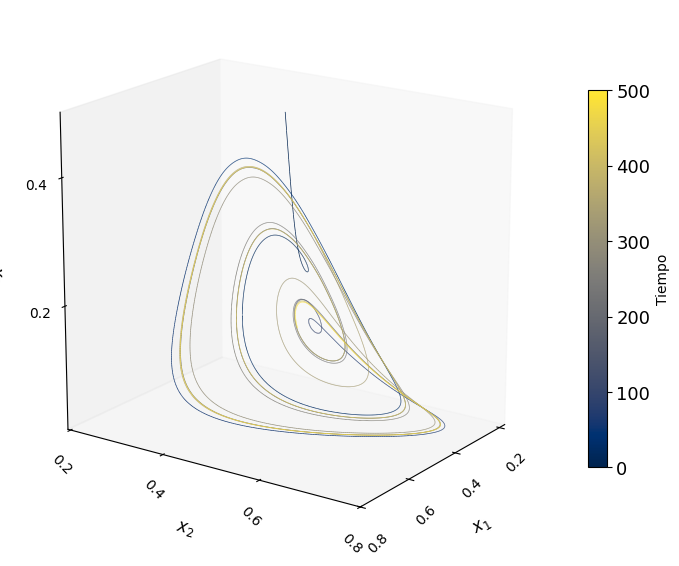

In [6]:
# %matplotlib notebook

# Creamos figura y ejes 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Asignamos color según la evolución temporal
time_sol = sol.t
c = t_span[-1] * (time_sol - time_sol.min()) / (time_sol.max() - time_sol.min())

# Creamos segmentos de línea
points = np.array([sol.y[0], sol.y[1], sol.y[2]]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Coloreamos los segmentos según 'c'
lc = Line3DCollection(segments, cmap='cividis', norm=plt.Normalize(np.min(c), np.max(c)))
lc.set_array(c)  # Define el gradiente según 'c'
lc.set_linewidth(0.5)  # Define el grosor de la línea
ax.add_collection3d(lc)

# Etiquetas de los ejes y título
ax.set_xlabel(r'$x_1$', fontsize=12, labelpad=10)
ax.set_ylabel(r'$x_2$', fontsize=12, labelpad=10)
ax.set_zlabel(r'$x_3$', fontsize=12, labelpad=10)
# ax.set_title('Espacio de fases', fontsize=14)

# Establecemos límites para que los ejes tengan proporciones iguales
xlim = [np.min(sol.y[0]), np.max(sol.y[0])]
ylim = [np.min(sol.y[1]), np.max(sol.y[1])]
zlim = [np.min(sol.y[2]), np.max(sol.y[2])]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

# Ajustamos las marcas de los ejes
ax.set_xticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_zticks([0.2, 0.4])

# Ajustes para evitar solapamiento
ax.tick_params(axis='x', labelsize=10, rotation=45)  # Eje X
ax.tick_params(axis='y', labelsize=10, rotation=-45) # Eje Y
ax.tick_params(axis='z', labelsize=10)   

# Quitamos el grid
ax.grid(False)

# Añadimos la barra de color
cbar = plt.colorbar(lc, ax=ax, shrink=0.7)
cbar.set_label('Tiempo')

# Ajustamos proporciones de los ejes
ax.set_box_aspect([np.ptp(xlim), np.ptp(ylim), np.ptp(zlim)])  # Proporciones iguales

# Ajustamos la vista personalizada
ax.view_init(elev=18, azim=35)

# Guardamos la figura (opcional)
# fig.savefig('espacio_fasico_4especies.png', dpi=600)

plt.show()

In [7]:
# fig.savefig('espacio_fasico_4especies.png', dpi=600)

## 1.3. Cálculo de los exponentes de Lyapunov
Para este sistema tenemos el siguiente Jacobiano:
$$
J_{ik}=\frac{\partial \dot x_i}{\partial x_k} = r_i\left[\left( 1-\sum_{j=1}^Na_{ij}x_j \right)\delta_{ik} -x_ia_{ik} \right].
$$

In [8]:
def compute_LCEs(x0, r, a, t_span, n_subdiv=100, method='RK45', max_step=None):
    """
    Calcula los exponentes de Lyapunov de un sistema continuo mediante el método QR.

    Parámetros
    ----------
    x0 : array de dimensión N
         Condición inicial del estado del sistema.
    r : array de dimensión N
        Parámetros r_i del sistema.
    a : array de dimensión N x N
        Matriz de interacciones a_{ij}.
    t_span : tuple (t0, tf)
        Intervalo de integración.
    n_subdiv : int, opcional (por defecto 100)
        Número de subdivisiones para la re-ortonormalización.
        Por ejemplo, si t_span=(0,1000) y n_subdiv=100, se aplica QR cada 10 unidades de tiempo.
    method : str, opcional (por defecto 'RK45')
        Método de integración de solve_ivp.
    max_step : float, opcional
        Paso máximo de integración para solver_ivp. Si None, no se limita el paso.

    Output
    -------
    LCEs : array de dimensión N
        Estimación final de los exponentes de Lyapunov.
    times : array
        Tiempos en que se realizó cada re-ortonormalización.
    LCE_convergence : array de dimensión (#reort x N)
        Evolución de la estimación de LCEs a lo largo del tiempo.
    """
    
    N = len(r)
    t0, tf = t_span
    
    # Matriz Phi inicial (identidad)
    Phi0 = np.eye(N)
    
    # Estado extendido inicial: [x0, Phi0 vectorizado]
    X0 = np.concatenate([x0, Phi0.flatten()])
    
    # Tiempo entre re-ortonormalizaciones
    dt = (tf - t0) / n_subdiv
    
    # Puntos en los que aplicaremos re-ortonormalización:
    times_eval = np.linspace(t0, tf, n_subdiv+1)
    
    # Inicializamos el acumulador de sumas logarítmicas
    log_factors = np.zeros(N)
    LCE_convergence = []
    times = []

    current_state = X0
    current_t = t0

    def extended_system(t, X):
        # Función interna para solve_ivp
        return _extended_system(t, X, r, a)

    for i in range(n_subdiv):
        # Integrar desde current_t hasta current_t+dt
        t_next = times_eval[i+1]
        
        sol = solve_ivp(extended_system,
                        (current_t, t_next),
                        current_state,
                        method=method,
                        vectorized=False,
                        dense_output=False,
                        max_step=max_step)  # Aquí aplicamos el control del paso
        
        # Extraemos el estado final
        X_final = sol.y[:, -1]
        x_final = X_final[:N]
        Phi_final = X_final[N:].reshape(N, N)
        
        # Aplicamos descomposición QR a Phi_final
        Q, R = np.linalg.qr(Phi_final)
        
        # Actualizamos los logaritmos de los factores de expansión
        diag_R = np.diag(R)
        # sumamos el log de los valores absolutos de la diagonal de R
        log_factors += np.log(np.abs(diag_R))
        
        # Cálculo temporal de los LCE
        elapsed_time = (t_next - t0)
        LCE_estimate = log_factors / elapsed_time
        LCE_convergence.append(LCE_estimate)
        times.append(t_next)
        
        # Reestablecemos Phi_final normalizado
        Phi_normalized = Q
        # Actualizamos el estado extendido para el siguiente tramo
        current_state = np.concatenate([x_final, Phi_normalized.flatten()])
        current_t = t_next

    LCE_convergence = np.array(LCE_convergence)
    times = np.array(times)
    LCEs = LCE_convergence[-1]  # LCE finales
    return LCEs, times, LCE_convergence


def _extended_system(t, X, r, a):
    """
    Función auxiliar para ser llamada dentro de compute_LCEs.
    Calcula dx/dt y dPhi/dt para el sistema extendido.
    """
    N = len(r)
    
    x = X[:N]
    Phi = X[N:].reshape(N, N)
    
    # dx/dt
    Ax = a.dot(x)
    dx = r * x * (1 - Ax)  # vectorizado
    
    # Jacobiano
    J = _jacobiano(x, r, a)
    
    # dPhi/dt = J(x)*Phi
    dPhi = J.dot(Phi)
    dPhi_flat = dPhi.flatten()
    
    return np.concatenate([dx, dPhi_flat])


def _jacobiano(x, r, a):
    """
    Calcula el jacobiano J(x).
    """
    N = len(r)
    J = np.zeros((N, N))
    Ax = a.dot(x)
    for i in range(N):
        sum_aijxj = Ax[i]
        for k in range(N):
            if i == k:
                J[i, k] = r[i] * ((1 - sum_aijxj) - x[i]*a[i, i])
            else:
                J[i, k] = -r[i]*x[i]*a[i, k]
    return J

Calculamos finalmente los LCEs:

In [9]:
LCEs = compute_LCEs(x0, r, a, t_span, n_subdiv=1000, max_step=0.1)
print(LCEs[0], (LCEs[2][:,1]).shape)

[ 0.01845063  0.00183361 -0.27939046 -1.0302858 ] (1000,)


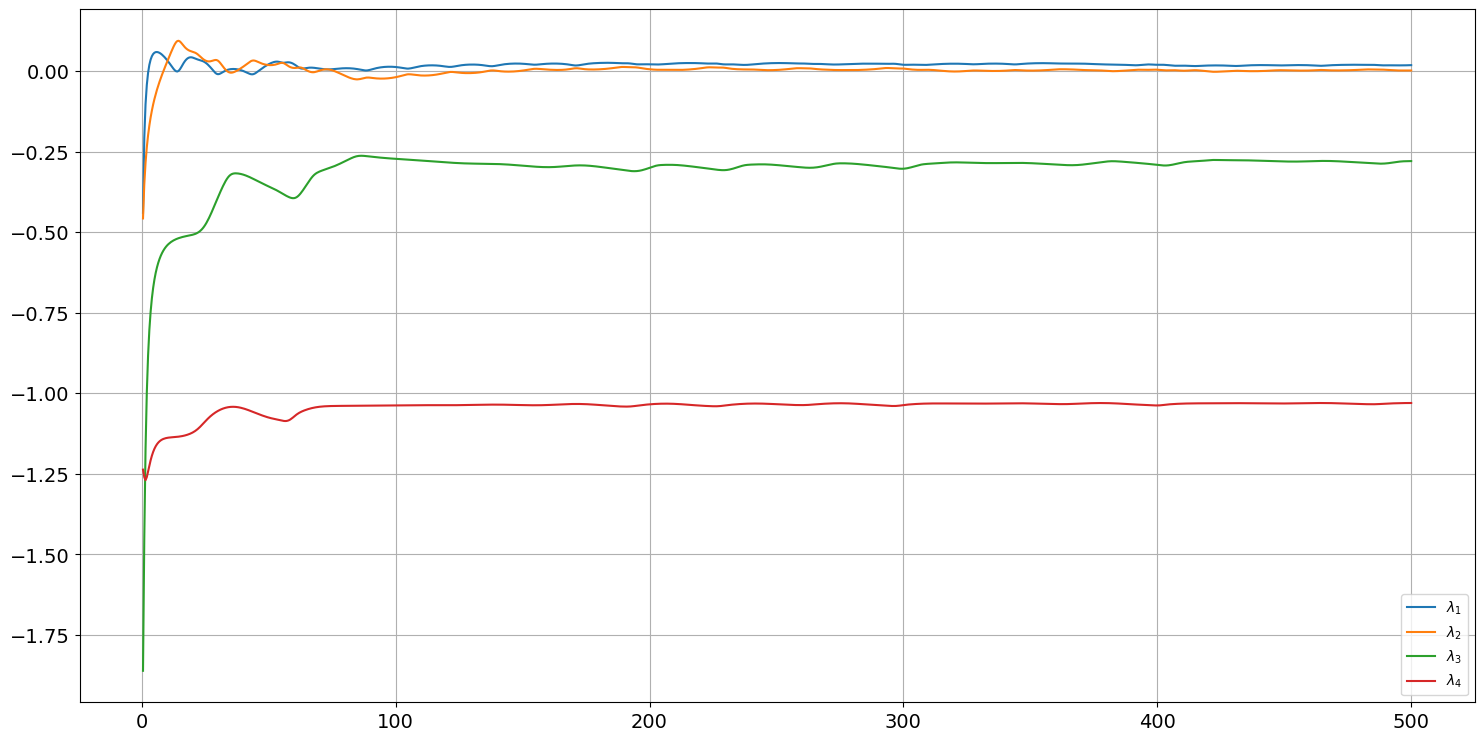

In [10]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(18, 9))  # Substituir plt.figure por plt.subplots

# Graficar los datos
plt.plot(LCEs[1], LCEs[2][:, 0], label=r'$\lambda_1$')
plt.plot(LCEs[1], LCEs[2][:, 1], label=r'$\lambda_2$')
plt.plot(LCEs[1], LCEs[2][:, 2], label=r'$\lambda_3$')
plt.plot(LCEs[1], LCEs[2][:, 3], label=r'$\lambda_4$')

# Personalizar los ejes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Añadir leyenda, guardar y mostrar
plt.legend()
plt.grid()
# fig.savefig('LCE_4especies.png', dpi=600)
plt.show()

---
# 2. Modelo estocástico

Aplicamos el método de Euler-Maruyama para resolver la ecuación de Languevin. Tras la discretización de $\Delta t = T/N$, obtenemos
$$
x_i^{(n+1)} = x_i^{(n)}+r_ix_i^{(n)}\left( 1-\sum_{j=1}^Na_{ij}x_j^{(n)} \right)\Delta t + \sigma_i x_i^{(n)}\sqrt{\Delta t}\zeta_i^{(n)}.
$$

In [11]:
def euler_maruyama(model, x0, t_span, dt, r, a, sigma):
    """
    Euler maruyama method
    :param system:  función definida antes
    :param x0: condición inicial (array de len N)
    :param t0: tiempo inicial (float)
    :param t_max: tiempo final (float)
    :param dt: step del tiempo (float)
    :param r: array con r_i
    :param a: matriz con a_ij
    :param sigma: array con sigma_i
    :return: (t_vals, x_vals), con x_vals un array (num_steps+1, N)
    """
    
    np.random.seed(2) # opcional
    N=len(x0) # en nuestro caso será 4
    t0 = t_span[0]
    t_max = t_span[-1]
    num_steps = int((t_max-t0)/dt)
    
    # guardamos los valores 
    t_vals = np.linspace(t0, t_max, num_steps+1)
    x_vals = np.zeros((num_steps+1,N))
    
    x_vals[0, :] = x0
    x = x0.copy()
    
    for n in range(num_steps): # para cada paso temporal
        t = t_vals[n]
        
        # parte determinista
        F = model(t,x,r,a) # también array de 4

        # vector del ruido
        
        for i in range(N): # para cada especie
            # introducimos la variable aletoria
            zetta = np.random.normal(0, 1)
            
            # hallamos el siguiente valor
            x[i] = x[i]+ F[i]*dt + sigma[i]*x[i]*np.sqrt(dt)*zetta
            
            # si baja del umbral, suponemos que se extingue
            if x[i] <= 1e-10:
                x[i] = 0
                
            x_vals[n+1,i] = x[i]    
    return t_vals, x_vals
    


## 2.1. Evolución temporal
Ahora lo aplicamos,

In [12]:
# tomamos los parámetros de antes
N=4
r = np.array(
    [1, 0.72, 1.53, 1.27]
)

a = np.array([
    [1, 1.09, 1.52, 0],
    [0, 1, 0.44, 1.36],
    [2.33, 0, 1, 0.47],
    [1.21, 0.51, 0.35, 1]
])

x0 = np.array([0.5, 0.5, 0.5, 0.5])
t_span = (0, 500)

# escogemos un paso de tiempo pequeño (IMPORTANTE)
dt = 1e-3

# definimos una intesidad para el ruido
sigma = 0* np.array([.08, .08, .08, .08])
# sigma = np.array([.01, .01, 1, 0.01]) # interesante

# aplicamos EM
t_vals_EM_4esp, x_vals_EM_4esp = euler_maruyama(system, x0, t_span, dt, r, a, sigma)
print('tiempo = ', t_vals_EM_4esp)
print('valores de x = ',x_vals_EM_4esp)

tiempo =  [0.00000e+00 1.00000e-03 2.00000e-03 ... 4.99998e+02 4.99999e+02
 5.00000e+02]
valores de x =  [[0.5        0.5        0.5        0.5       ]
 [0.4995975  0.499856   0.4993115  0.49966027]
 [0.49919613 0.49971237 0.49862531 0.4993215 ]
 ...
 [0.45879881 0.41597971 0.04232461 0.30215435]
 [0.45880956 0.41602598 0.0423082  0.30212202]
 [0.45882031 0.41607225 0.0422918  0.30208969]]


In [13]:
print('min en x_2', np.min(x_vals_EM_4esp[:,1]))

min en x_2 0.19252773709029983


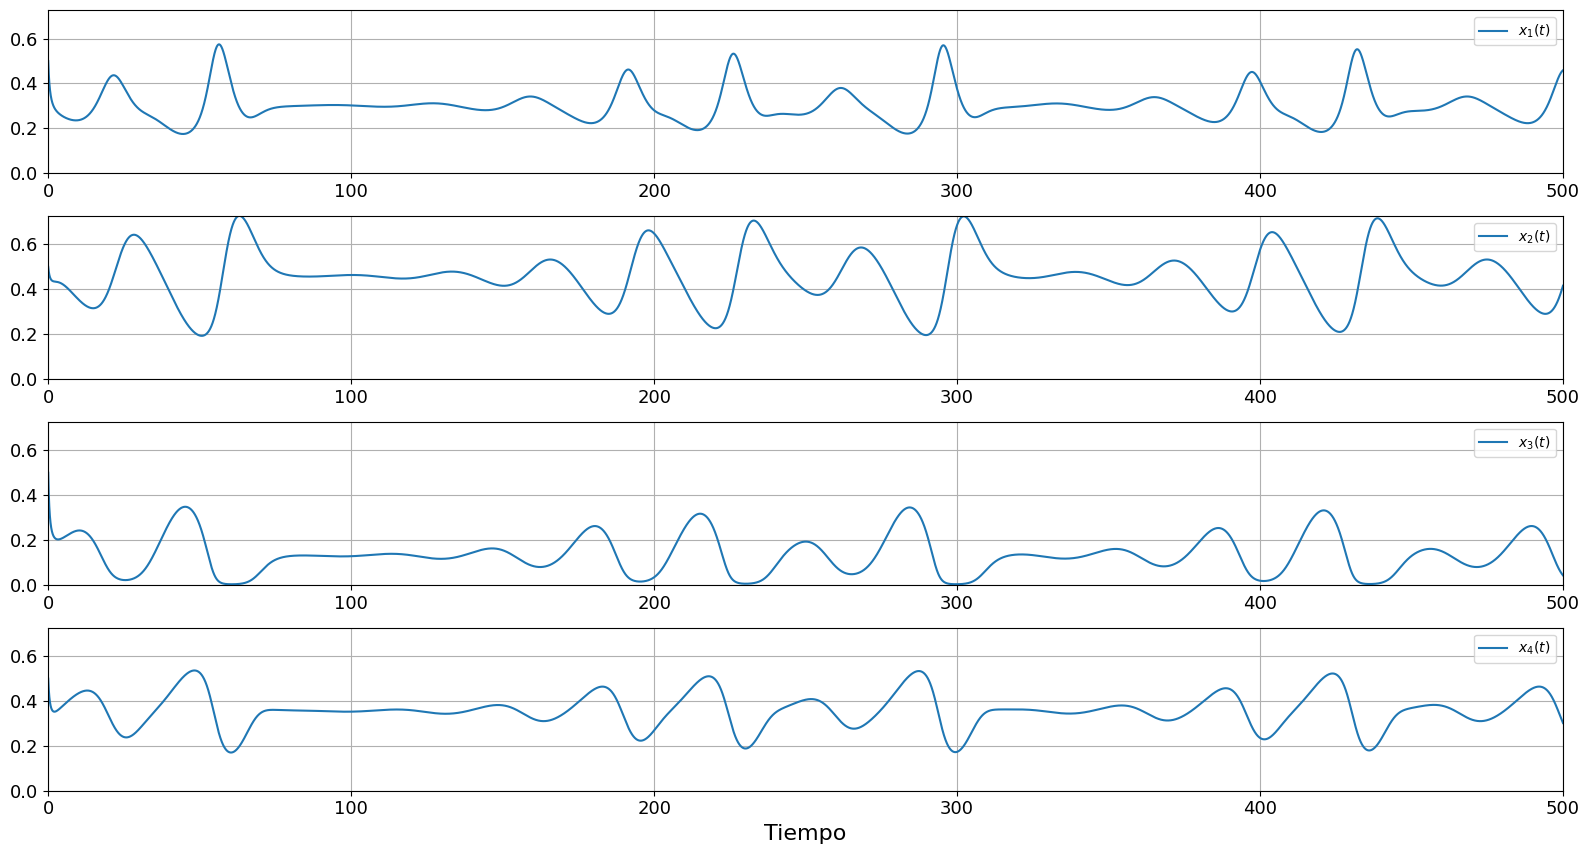

In [14]:
 # %matplotlib notebook

# creamos la gráfica
fig_em, ax_em = plt.subplots(4, 1, figsize=(16,9))

ax_em[0].plot(t_vals_EM_4esp, x_vals_EM_4esp[:,0], label=f'$x_1(t)$')
ax_em[1].plot(t_vals_EM_4esp, x_vals_EM_4esp[:,1], label=f'$x_2(t)$')
ax_em[2].plot(t_vals_EM_4esp, x_vals_EM_4esp[:,2], label=f'$x_3(t)$')
ax_em[3].plot(t_vals_EM_4esp, x_vals_EM_4esp[:,3], label=f'$x_4(t)$')

# ajustamos las etiquetas y el título
max_y = x_vals_EM_4esp.max()
for i in range(4):
    ax_em[i].set_ylim([0, max_y])
    ax_em[i].set_xlim([t_span[0], t_span[1]])
    ax_em[i].legend()
    ax_em[i].grid(True)

ax_em[3].set_xlabel('Tiempo', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 


# mostramos la gráfica
plt.show()

# fig_em.savefig('evol_temp_4especies_ruido.png', dpi=600)


## 2.2. Representación del espacio de fases
También podemos hallar su espacio de fases como hicimos cuando estábamos en el caso determinista:

Forma de lineas: (500000, 2, 3)
Forma de col: (500001,)


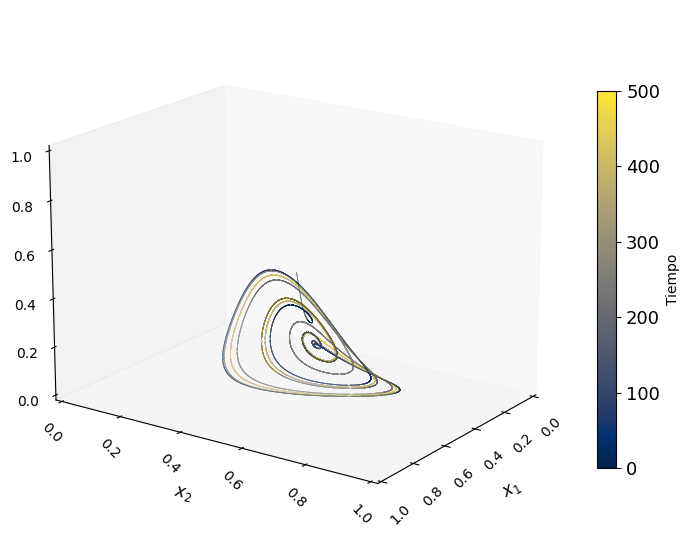

In [15]:
 # %matplotlib notebook


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# asignamos el color segun el tiempo
time_val = t_vals_EM_4esp[:]
col = t_span[1] * (time_val - time_val.min()) / (time_val.max() - time_val.min())

# creamos las lineas
puntos = np.array([x_vals_EM_4esp[:,0], x_vals_EM_4esp[:,1], x_vals_EM_4esp[:,2]]).T.reshape(-1, 1, 3)
lineas = np.concatenate([puntos[:-1], puntos[1:]], axis=1)
print("Forma de lineas:", lineas.shape)  # Debe ser (n_lines, 2, 3)
print("Forma de col:", col.shape)  


# coloreamos según col 
LC = Line3DCollection(lineas, cmap='cividis', norm = plt.Normalize(np.min(col), np.max(col)))
LC.set_array(col)
LC.set_linewidth(0.5)
ax.add_collection3d(LC)

# etiquetamos ejes y titulos
ax.set_xlabel(r'$x_1$', fontsize=12, labelpad=10)
ax.set_ylabel(r'$x_2$', fontsize=12, labelpad=10)
ax.set_zlabel(r'$x_3$', fontsize=12, labelpad=10)

# ponemos los ejes
xlim = [np.min(x_vals_EM_4esp[:,0]), np.max(x_vals_EM_4esp[:,0])]
ylim = [np.min(x_vals_EM_4esp[:,1]), np.max(x_vals_EM_4esp[:,1])]
zlim = [np.min(x_vals_EM_4esp[:,3]), np.max(x_vals_EM_4esp[:,3])]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# ax.set_zlim(zlim)

# ax.set_xticks([0.2, 0.4, 0.6, 0.8])
# ax.set_yticks([0.2, 0.4, 0.6, 0.8])
# ax.set_zticks([0.2, 0.4])

ax.tick_params(axis='x', labelsize=10, rotation=45)  
ax.tick_params(axis='y', labelsize=10, rotation=-45) 
ax.tick_params(axis='z', labelsize=10)  


# Quitamos el grid
ax.grid(False)

# Añadimos la barra de color
cbar = plt.colorbar(LC, ax=ax, shrink=0.7)
cbar.set_label('Tiempo')

# Ajustamos proporciones de los ejes
ax.set_box_aspect([np.ptp(xlim), np.ptp(ylim), np.ptp(zlim)])  # Proporciones iguales

# Ajustamos la vista personalizada
ax.view_init(elev=18, azim=35)

plt.show()

# Guardamos la figura (opcional)
# fig.savefig('espacio_fasico_4especies_ruido.png', dpi=600)




## 2.3. Cálculo de los exponentes de Lyapunov

Necesitamos un procedimiento diferente al aplicado en el caso determinista. Nos basamos en la aproximación usada en el paper de Wolf et al., donde se haya el mayor LCE reconstruyendo el atractor de una serie temporal.

In [16]:

def nearest_neighbour_4D(data_4d, idx, min_separation = 50):
    '''
    Busca el punto más cercano para el punto data_4d[idx],
    excluyendo los puntos que están muy próximos en el tiempo.
    
    :param data_4d: ndarray, shape (N,4)
        Matriz de datos en R^4 
    :param idx: int
        Índice del punto de referencia
    :param min_separation: int
        Número mínimo de índices (pasos de tiempo) para evitar vecinos de la misma órbita
    
    :return: nn_idx: int
        Índice del vecino más cercano
    :return dist_min: float
        Distancia euclídea mínima encontrada
    '''
    
    ref_point = data_4d[idx]
    
    # hallamos todas las distancias euclideas
    dists = np.linalg.norm(data_4d - ref_point, axis = 1)
    # excluimos el propio punto
    dists[idx] = np.inf
    
    # excluimos puntos en un rango temporal muy cercano
    start_excl = max(0, idx - min_separation)
    end_excl = min(len(data_4d), idx + min_separation)
    dists[start_excl:end_excl] = np.inf
    
    nn_idx = np.argmin(dists)
    dist_min = dists[nn_idx]
    return nn_idx, dist_min


In [27]:
def estimate_LCE1_Wolf(data_4d, evol_time = 30, min_separation = 50, dt = 1.0, max_replacements = 1000, start_indices = None):
    '''
    
    Estimamos el mayor exponentes de Lyapunov usando el método 
    de Wolf  (fixed time) para datos en R^4
    
    :param data_4d: ndarray, shape (N,4)
        Cada fila es un vector (x1, x2, x3, x4) en el instante de muestreo
    :param evol_time: int
        Número de pasos que se deja evolucionar cada par antes de renormalizar
    :param min_separation: int
        Número mínimo de pasos para excluir puntos muy próximos en tiempo
    :param df: float 
        Intervalo de muestreo en unidades de tiempo
    :param max_replacements: int
        Número máximo de renormalizaciones a realizar
    :param start_indices: list o array (opcional)
        Lista de índices iniciales a usar como puntos de referencia para promediar la estimación
        
    :return: lambda1: float
        Estimación del mayor LCE 
    '''
    
    # N = len(data_4d)
    N = data_4d.shape[1]
    if start_indices is None:
        start_indices = [0] # se puede promediar
        
    lambda_estimates = [] # para almacenar la estimación de cada referencia
    
    for init_idx in start_indices:
        idx_f = init_idx
        log_sum = 0.0
        count = 0
        
        # iteramos mientras se pueda evolucionar el referencia y sin superar el máximo de iteraciones
        while (idx_f + evol_time < N) and (count < max_replacements):
            # buscamos vecino más cercano para el referencia más cercano
            idx_n, dist_init = nearest_neighbour_4D(data_4d, idx_f, min_separation)
            
            # vemos que la distancia inicial es valida
            if np.isinf(dist_init) or dist_init < 1e-12:
                break
            # definimos los índices después de la evolución
            idx_f_next = idx_f + evol_time
            idx_n_next = idx_n + evol_time
            
            if idx_f_next >= N or idx_n_next >= N:
                break
            
            # calculamos la separación final
            dist_final = np.linalg.norm(data_4d[idx_f_next] - data_4d[idx_n_next])
            
            # acumulamos el logaritmo del crecimiento
            log_sum += np.log(dist_final / dist_init)
            count += 1
            
            # renormalizamos
            idx_f = idx_f_next
            
        if count > 0:
            lambda_local = (log_sum / (count * evol_time * dt))
            print('lambda_local: ', lambda_local) # DEBUG
            lambda_estimates.append(lambda_local)
            print('lambda_estimates: ',lambda_estimates) # DEBUG
            
    print(len(lambda_estimates)) # DEBUG
    
    if len(lambda_estimates) > 0:
        lambda1 = np.mean(lambda_estimates)
    else:
        print('Entra mal. len(lambda_estimates):', len(lambda_estimates)) # DEBUG
        lambda1 = 0
    
    return lambda1

In [28]:
# lo aplicamos a nuestro sistema de 4 especies
t = t_vals_EM_4esp  
dt = t[1] - t[0]

# definimos nuestro array de datos en R^4
x1 = x_vals_EM_4esp[:,0]
x2 = x_vals_EM_4esp[:,1]
x3 = x_vals_EM_4esp[:,2]
x4 = x_vals_EM_4esp[:,3]

data_4d = np.array([x1, x2, x3, x4])
# print(data_4d.shape[1])

# Parámetros para el algoritmo
evol_time = 50         # número de pasos para evolución entre renormalizaciones
min_sep = 10           # separación mínima en el tiempo para evitar vecinos triviales
max_rep = 2000         # máximo número de renormalizaciones

# Podemos usar varios puntos de inicio para mejorar la estadística
# start_indices = list(range(0, 500, 50))  # por ejemplo, índices 0, 50, 100, ... hasta 450
start_indices = [0, 50, 100, 150, 200]

# estimamos lambda1
lambda1 = estimate_LCE1_Wolf(data_4d, evol_time=evol_time, 
                                min_separation=min_sep, dt=dt, 
                                max_replacements=max_rep, start_indices=start_indices)

print(f"Estimación del mayor exponente de Lyapunov: λ₁ ≈ {lambda1:.5f} [1/segundo]")
print(lambda1)

# vemos una de las series para ver los datos
plt.figure(figsize=(8,4))
plt.plot(t, x1, label='x1(t)')
plt.xlabel("Tiempo")
plt.ylabel("x1(t)")
plt.title("Ejemplo de serie temporal x1")
plt.xlim([0, t[-1]])
plt.ylim([0, np.max(data_4d)])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

IndexError: index 50 is out of bounds for axis 0 with size 4

In [19]:
# ejecutamos lo de arriba